# Tarea 5. Predicción del valor de las acciones en la bolsa

1. Suscríbase a las API de Yahoo-Finance y Alpha-Vantage.

2. Baje un conjunto  de datos que incluya la mayor cantidad de datos para un conjunto de empresas seleccioandas por usted.

3. Incluya todas las variables que considere necesario: precio apertura, promedio, alto, bajo , cierre, volumen transado.

4. Construya un modelo predictivo con un horizonte de tamaño n, que usted define de acuerdo con la longitud del periodo de cada observación. Mínimo 5 observaciones adelante.mpetodo

5. Calcule franja de confianza o credibilidad. Para ellos investigue regresión cuantil, boostrap u otro método.

6. Opcionalmente use el modelo TFT u otro similar con la librería Pytorch-forecasting, que le permite calcular las franjas directamente.


# Librerias.

In [2]:
import pandas as pd
import tensorflow as tf
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print('version de tf: ', tf.__version__)
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

version de tf:  2.9.2


# Funciones requeridas.

## Funciones para graficos

In [3]:
def create_time_steps(length):
    return list(range(-length, 0))

In [4]:
def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

In [5]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
    plt.title(title)
    plt.legend()

    plt.show()

In [6]:
def plot_serie_prediction(y_test, y_pred,rms, epochs):
    plt.plot(np.arange(0, len(y_test)), y_test, marker='.', label="verdadero")
    plt.plot(np.arange(0, len(y_test)), y_pred, marker='+', label="predicho")
    plt.xlabel('Time Step')
    plt.annotate("rms = "+str(round(rms,2)) , xy=(100, 140), size = 15)
    #plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
    #plt.annotate("epochs=40" , xy=(100, 143), size = 15)
    plt.title("Intervalo de predicción a un día. Escala original", size = 20)
    plt.legend()
    plt.show()

## Funcion para preparar datos de entrenamiento

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        step: Cada cuántas observaciones deben tomarse. Para secuencias muy largas
              que no cambia mucho localmente
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [8]:
tf.random.set_seed(13)
np.random.seed(13)

## Importacion de los datos.

In [9]:
df = pd.read_csv('BTC-USD.csv')
df['Date']=pd.to_datetime(df['Date'])
df[0:5] 

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-10-01,387.427002,391.378998,380.779999,383.614990,383.614990,26229400
1,2014-10-02,383.988007,385.497009,372.946014,375.071991,375.071991,21777700
2,2014-10-03,375.181000,377.695007,357.859009,359.511993,359.511993,30901200
3,2014-10-04,359.891998,364.487000,325.885986,328.865997,328.865997,47236500
4,2014-10-05,328.915985,341.800995,289.295990,320.510010,320.510010,83308096


In [10]:
features_considered = ['Open','High','Low','Close']

In [11]:
features = df[features_considered]
features.index = df['Date']
features.head()

,Open,High,Low,Close
Date,,,,
2014-10-01,387.427002,391.378998,380.779999,383.614990
2014-10-02,383.988007,385.497009,372.946014,375.071991
2014-10-03,375.181000,377.695007,357.859009,359.511993
2014-10-04,359.891998,364.487000,325.885986,328.865997
2014-10-05,328.915985,341.800995,289.295990,320.510010


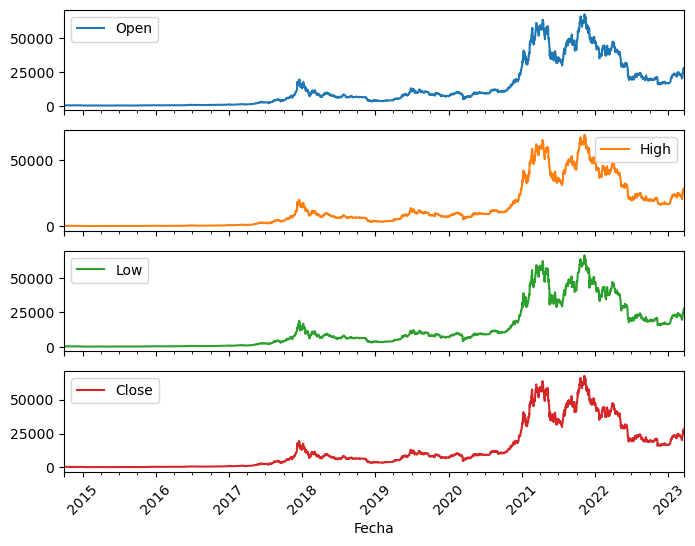

In [12]:
features.plot(subplots=True, rot=45, xlabel='Fecha')
plt.show()

## Separacion(Entrenamiento-Validación) y Normalización.

In [13]:
TRAIN_SPLIT = int(len(df)*0.8)
TRAIN_SPLIT

2475

In [14]:
from sklearn.preprocessing import MinMaxScaler

"Para normalizar los datos podemos hacerlo manualmente restando la media del conjunto de entrenamiento y dividiéndolo por la desviación estándar. También podemos aplicar la función ```MinMaxScaler``` de la ```librería sklearn.preprocessing```. De esta manera, los datos quedarían normalizados y listos para su análisis."

In [15]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
dataset

array([[-0.63732516, -0.63618881, -0.64049665, -0.63823339],
       [-0.63761078, -0.6366624 , -0.64117254, -0.63894234],
       [-0.6383422 , -0.63729058, -0.6424742 , -0.64023361],
       ...,
       [ 1.57033728,  1.62218704,  1.64816539,  1.65676213],
       [ 1.65937584,  1.62920504,  1.67708231,  1.63423634],
       [ 1.63799643,  1.58517615,  1.71971405,  1.64526381]])

In [16]:
dataset = features.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)))

In [17]:
past_history = 50
future_target = 5
STEP = 1
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


Este código es un ejemplo de cómo utilizar la función ```multivariate_data``` para preparar los datos de entrenamiento y validación para un modelo de aprendizaje automático que predice un solo valor futuro en el tiempo. Los parámetros utilizados son los siguientes:

```dataset```: el conjunto de datos de entrada para el modelo.

```past_history```: el tamaño de la ventana para crear las secuencias de entrada.

```future_target```: el número de observaciones futuras que se desea predecir.


```STEP```: el número de observaciones que se toman para cada secuencia,se refiere al número de observaciones que se toman para cada secuencia al crear las ventanas de datos de entrada y salida para un modelo de aprendizaje automático. Es decir, si se tiene una serie temporal de datos y se desea crear secuencias de 10 observaciones cada una, y se define un "step" de 2, entonces la primera secuencia sería desde la observación 1 hasta la 10, la segunda secuencia sería desde la observación 3 hasta la 12, la tercera secuencia sería desde la observación 5 hasta la 14, y así sucesivamente.

El "step" se utiliza para controlar la cantidad de solapamiento entre las secuencias de entrada y salida. Si se define un "step" pequeño, las secuencias se superpondrán significativamente, lo que puede aumentar la cantidad de datos que se utilizan para entrenar el modelo, pero puede causar problemas de sobreajuste. Si se define un "step" grande, las secuencias no se superpondrán tanto, lo que puede reducir la cantidad de datos que se utilizan para entrenar el modelo, pero puede dar lugar a una mejor generalización del modelo.

En general, el valor de "step" depende del tamaño de la ventana de tiempo que se está utilizando, así como de la longitud de la serie temporal. En algunos casos, puede ser necesario ajustar el valor de "step" para obtener el mejor rendimiento del modelo.


In [18]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (50, 4)

 Target temperature to predict : (5,)


In [21]:
BATCH_SIZE = 32
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Este código se encarga de crear los objetos ```train_data_multi``` y ```val_data_multi``` que serán utilizados para entrenar y validar el modelo de aprendizaje automático.

Primero, se utiliza la función ```tf.data.Dataset.from_tensor_slices()``` para crear un objeto de conjunto de datos a partir de los datos de entrenamiento y validación (```x_train_multi```, ```y_train_multi```, ```x_val_multi```, y ```y_val_multi```). Esto divide los datos en pares de entradas y salidas correspondientes.

Luego, se utiliza el método ```cache()``` para almacenar en caché los datos del conjunto de entrenamiento en memoria, lo que puede mejorar el rendimiento del entrenamiento. El tamaño del búfer utilizado para el barajado se define mediante la variable ```BUFFER_SIZE```.

Después, se utiliza el método ```batch()``` para agrupar los datos en lotes de tamaño ```BATCH_SIZE```, lo que permite que el modelo procese varios ejemplos de entrenamiento a la vez. El método ```repeat()``` se utiliza para repetir el conjunto de datos indefinidamente, lo que es útil para entrenar modelos que necesitan iterar varias veces sobre el conjunto de datos completo.

Por último, se crea el conjunto de datos de validación ```val_data_multi``` utilizando el método ```batch()``` para agrupar los datos en lotes del mismo tamaño que el conjunto de entrenamiento, y se utiliza el método ```repeat()``` para repetir el conjunto de datos indefinidamente.

In [22]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

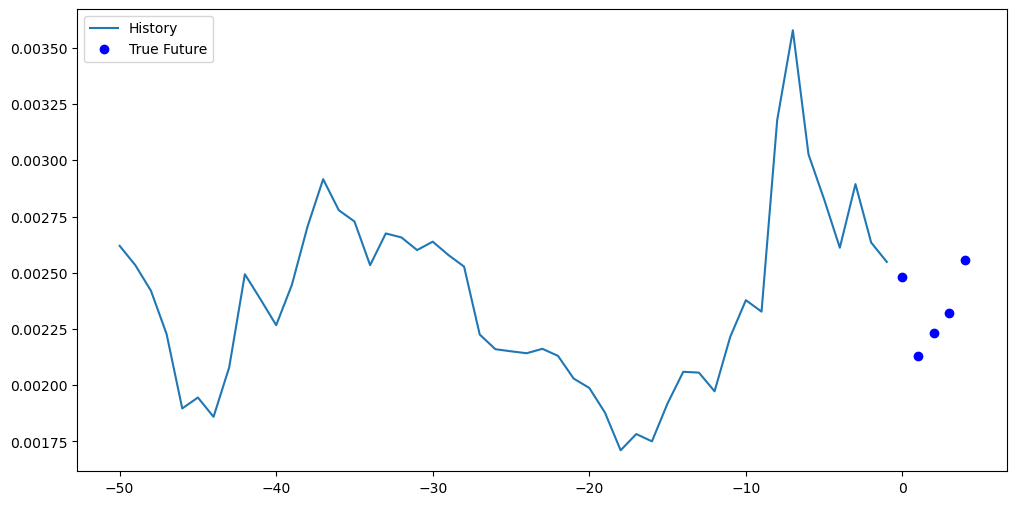

In [23]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

## Red neuronal Multicapa

In [29]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64, input_shape=x_train_multi.shape[-2:], return_sequences=True))
multi_step_model.add(tf.keras.layers.GRU(32, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(5))


In [30]:
multi_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 64)            17664     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 27,237
Trainable params: 27,237
Non-trainable params: 0
_________________________________________________________________


In [33]:
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [39]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=19)

Epoch 1/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0071 - val_loss: 0.0612
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0084 - val_loss: 0.0274
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0073 - val_loss: 0.0248
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0086 - val_loss: 0.0427
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0088 - val_loss: 0.0244
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0072 - val_loss: 0.0608
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0086 - val_loss: 0.0245
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0091 - val_loss: 0.0248
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0071 - val_loss: 0.0526
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0087 - val_lo

Se utiliza un conjunto de datos creado a partir de las funciones ``` multivariate_data()```  y ``` tf.data.Dataset.from_tensor_slices()``` . Este conjunto de datos se pasa al método ``` fit()```  del modelo y se configura mediante los parámetros ``` epochs```  y ``` steps_per_epoch``` . El modelo entrena en lotes de datos de tamaño ``` BATCH_SIZE```  (32 en este caso) y procesa un número limitado de lotes por época (200 en este caso).

3/3 [==============================] - 0s 5ms/step


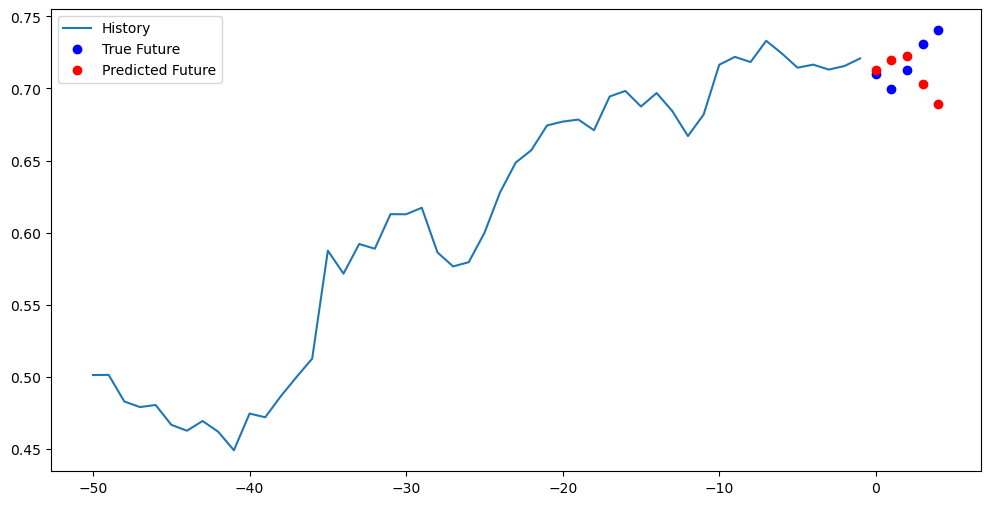

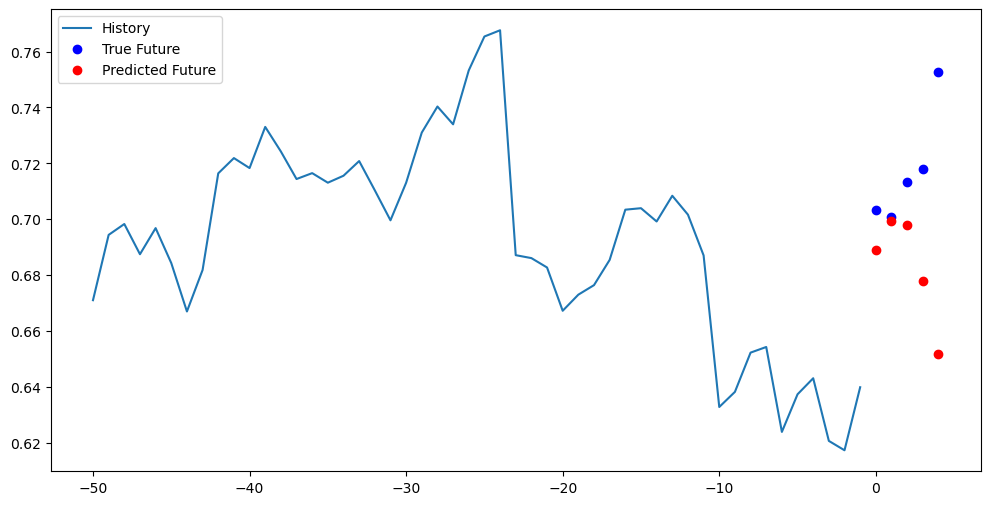

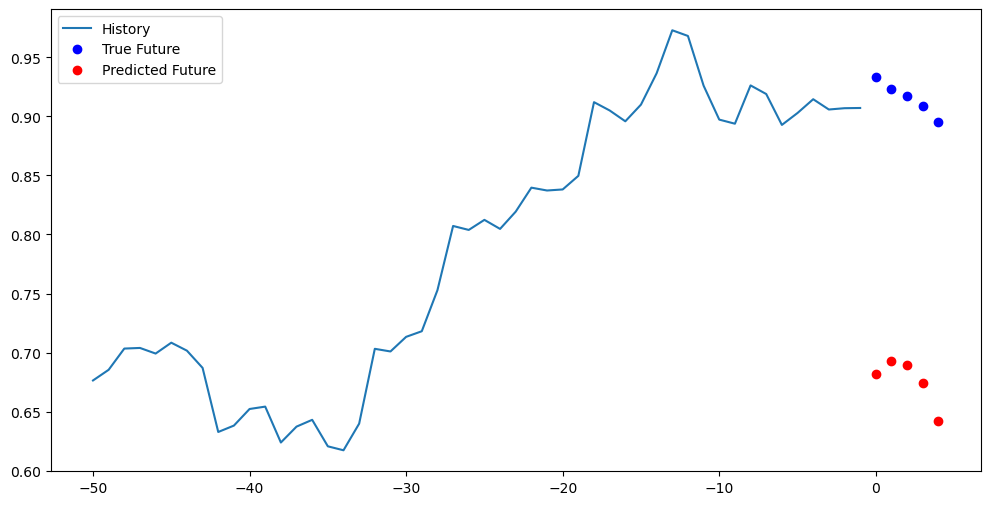

In [40]:
predictions = multi_step_model.predict(val_data_multi.take(3).map(lambda x, y: x))
for i, (x, y) in enumerate(val_data_multi.take(3)):
    multi_step_plot(x[0], y[0], predictions[i])

# Intervalo de confianza 

Para realizar el intervalo de confianza en la serie de tiempo, utilizamos una técnica llamada "block bootstrap". Esta técnica consiste en generar muestras de la serie de tiempo original de manera aleatoria, pero manteniendo la estructura de autocorrelación que posee la serie. Esto se logra seleccionando bloques de observaciones consecutivas en la serie y replicándolos para formar las muestras bootstrap. 

Para ello, se divide la serie original en bloques de tamaño $m$ y se realiza un muestreo aleatorio con reemplazo dentro de cada bloque, de manera que se generan nuevas muestras de la serie temporal que preservan la estructura de autocorrelación de la serie original. Luego, se concatenan las muestras de cada bloque en el mismo orden en que aparecen en la serie original para generar una nueva serie temporal de tamaño $n$ (el mismo que la serie original).

Un ejemplo de cómo se aplicaría esto a una serie de tiempo del 1 al 12, siguiendo el mismo procedimiento que se describió anteriormente:

Supongamos que tomamos bloques de tamaño 3, de manera que la serie original se divide en 4 bloques: $[1, 2, 3]$, $[4, 5, 6]$, $[7, 8, 9]$ y $[10, 11, 12]$.

Para cada bloque, se realiza un muestreo aleatorio con reemplazo, generando nuevas muestras de tamaño 3 que preservan la estructura de autocorrelación de la serie original. Supongamos que, por ejemplo, se generan las siguientes muestras:

* Para el bloque $[1, 2, 3]$, se generan las siguientes muestras: $[1, 1, 3]$, $[3, 2, 2]$, $[2, 3, 1]$.
* Para el bloque $[4, 5, 6]$, se generan las siguientes muestras: $[5, 6, 6]$, $[4, 5, 6]$, $[6, 6, 5]$.
* Para el bloque $[7, 8, 9]$, se generan las siguientes muestras: $[7, 8, 7]$, $[9, 9, 8]$, $[8, 7, 9]$.
* Para el bloque $[10, 11, 12]$, se generan las siguientes muestras: $[11, 11, 10]$, $[11, 12, 11]$, $[10, 11, 12]$.
* Luego, se concatenan las muestras de cada bloque en el mismo orden en que aparecen en la serie original:

$[1, 1, 3, 5, 6, 6, 7, 8, 7, 11, 11, 10]$

De esta manera, se ha generado una nueva serie temporal de tamaño 12 que preserva la estructura de autocorrelación de la serie original, ademas , se preserva la dependencia temporal de la serie de tiempo mientras se obtienen estimaciones del intervalo de confianza para las estadísticas de interés. El block bootstrap es una herramienta útil en el análisis de series de tiempo para obtener estimaciones robustas y confiables de las incertidumbres de las estimaciones.

De manera similar se puede hacer para una serie de tiempo multivariada.

Supongamos que tenemos una matriz de datos $X$ de dimensiones $n\times m$, donde $n$ es el número de observaciones y $m$ es el número de variables. Para aplicar Block Bootstrap, se pueden seguir los siguientes pasos:

Dividir la matriz $X$ en bloques de tamaño $k$, donde $k$ es el número de observaciones por bloque. De esta forma, se obtienen $B$ bloques, donde $B=\lceil n/k \rceil$ y el último bloque puede tener menos observaciones si $n$ no es múltiplo de $k$.
Para cada bloque $i$, se realiza un muestreo aleatorio con reemplazo de las filas del bloque, generando un nuevo bloque $i'$ de tamaño $k$. Esto se puede hacer utilizando la función ``` np.random.choice()```  de ``` NumPy``` .
Se concatenan todos los bloques $i'$ generados en el paso anterior para formar una nueva matriz $X'$ de tamaño $n\times m$. Es importante preservar el orden de las filas para no alterar la estructura de autocorrelación.
Se repiten los pasos 2 y 3 un número $B'$ de veces para obtener $B'$ muestras bootstrap de la matriz $X$.
Cabe destacar que, al trabajar con datos multivariados, es importante tener en cuenta las correlaciones entre las variables para preservar la estructura de autocorrelación y la distribución conjunta de los datos.

In [41]:
import numpy as np

def block_bootstrap_multivariate(X, block_size, n_samples):
    """
    Realiza el block bootstrap multivariado sobre una matriz de datos X.
    
    Parámetros:
    - X: matriz de datos (n x m)
    - block_size: tamaño de los bloques (entero)
    - n_samples: número de muestras bootstrap a generar (entero)
    
    Retorna:
    - boot_samples: matriz de muestras bootstrap (n_samples x n x m)
    """
    
    # Obtenemos las dimensiones de la matriz de datos
    n, m = X.shape
    
    # Definimos el número de bloques
    n_blocks = n // block_size
    
    # Creamos una matriz para almacenar las muestras bootstrap
    boot_samples = np.zeros((n_samples, n, m))
    
    # Iteramos sobre cada bloque de datos
    for block_idx in range(n_blocks):
        start_idx = block_idx * block_size
        end_idx = start_idx + block_size

        # Creamos una matriz con los datos del bloque actual
        block_data = X[start_idx:end_idx, :]

        # Iteramos para generar las muestras bootstrap para el bloque actual
        for sample_idx in range(n_samples):

            # Creamos una matriz vacía para almacenar la muestra bootstrap del bloque actual
            boot_block_data = np.zeros((block_size, m))

            # Iteramos sobre cada variable y hacemos un muestreo aleatorio con reemplazo
            for var_idx in range(m):
                boot_block_data[:, var_idx] = np.random.choice(block_data[:, var_idx], size=block_size, replace=True)

            # Guardamos la muestra bootstrap del bloque actual en la matriz general de muestras bootstrap
            boot_samples[sample_idx, start_idx:end_idx, :] = boot_block_data

    return boot_samples

Vamos a calcular un intervalo de confianza para el primer lote de datos del conjunto de validación. Por lo tanto, tenemos que:

In [42]:
dataset[TRAIN_SPLIT+1:TRAIN_SPLIT+past_history+1]

array([[0.50579907, 0.50133393, 0.49124796, 0.48936591],
       [0.4890483 , 0.48288696, 0.48466458, 0.48263151],
       [0.4830871 , 0.47901249, 0.47526586, 0.48441701],
       [0.48463118, 0.48044505, 0.46826673, 0.46896016],
       [0.46999139, 0.46672001, 0.46713345, 0.46363002],
       [0.46339761, 0.46260117, 0.46899594, 0.46528504],
       [0.46542478, 0.46935336, 0.46886759, 0.46919878],
       [0.46937484, 0.46187082, 0.45902388, 0.45467145],
       [0.45510015, 0.44904348, 0.4408579 , 0.43967659],
       [0.43963397, 0.47450561, 0.4433534 , 0.47385657],
       [0.47440448, 0.47194026, 0.47686944, 0.47686022],
       [0.4768845 , 0.48659733, 0.48159064, 0.49568303],
       [0.49599861, 0.49984999, 0.5022364 , 0.5062322 ],
       [0.50633753, 0.51260243, 0.50913827, 0.52192833],
       [0.52257164, 0.58747714, 0.53036565, 0.55141913],
       [0.55065423, 0.57154293, 0.54780115, 0.58212762],
       [0.58371136, 0.59209079, 0.58436195, 0.59086744],
       [0.59101795, 0.58883901,

In [43]:
x_val_multi[1]

array([[0.50579907, 0.50133393, 0.49124796, 0.48936591],
       [0.4890483 , 0.48288696, 0.48466458, 0.48263151],
       [0.4830871 , 0.47901249, 0.47526586, 0.48441701],
       [0.48463118, 0.48044505, 0.46826673, 0.46896016],
       [0.46999139, 0.46672001, 0.46713345, 0.46363002],
       [0.46339761, 0.46260117, 0.46899594, 0.46528504],
       [0.46542478, 0.46935336, 0.46886759, 0.46919878],
       [0.46937484, 0.46187082, 0.45902388, 0.45467145],
       [0.45510015, 0.44904348, 0.4408579 , 0.43967659],
       [0.43963397, 0.47450561, 0.4433534 , 0.47385657],
       [0.47440448, 0.47194026, 0.47686944, 0.47686022],
       [0.4768845 , 0.48659733, 0.48159064, 0.49568303],
       [0.49599861, 0.49984999, 0.5022364 , 0.5062322 ],
       [0.50633753, 0.51260243, 0.50913827, 0.52192833],
       [0.52257164, 0.58747714, 0.53036565, 0.55141913],
       [0.55065423, 0.57154293, 0.54780115, 0.58212762],
       [0.58371136, 0.59209079, 0.58436195, 0.59086744],
       [0.59101795, 0.58883901,

In [44]:
# Generar muestras bootstrap de x_original
dataset.shape
boot_samples = block_bootstrap_multivariate(dataset, block_size=2, n_samples=10)

# Seleccionar únicamente los últimos valores de cada muestra bootstrap
val_boot_samples = boot_samples[:,TRAIN_SPLIT+1:TRAIN_SPLIT+past_history+1, :]
val_boot_samples.shape

(10, 50, 4)

In [45]:
predictions = multi_step_model.predict(x_val_multi)

18/18 [==============================] - 0s 4ms/step


In [46]:
predictions

array([[0.7127406 , 0.7194115 , 0.7224354 , 0.70330334, 0.68901175],
       [0.6891345 , 0.69941145, 0.6980737 , 0.67804724, 0.651786  ],
       [0.68167144, 0.692971  , 0.6893593 , 0.67432654, 0.6417808 ],
       ...,
       [0.35177705, 0.33355018, 0.3494337 , 0.3168878 , 0.32952172],
       [0.36973414, 0.35215324, 0.36693898, 0.33409655, 0.34782025],
       [0.35628587, 0.34593058, 0.35838738, 0.32355177, 0.33668274]],
      dtype=float32)

In [47]:
predictions_B = multi_step_model.predict(val_boot_samples)
predictions_B.shape

1/1 [==============================] - 0s 12ms/step


(10, 5)

In [48]:
predictions_B

array([[0.69099265, 0.7017638 , 0.7003694 , 0.6832854 , 0.65542877],
       [0.70486075, 0.7140511 , 0.7151899 , 0.69706863, 0.6761518 ],
       [0.7089744 , 0.7157484 , 0.7176416 , 0.7006944 , 0.68037194],
       [0.6927898 , 0.70066047, 0.7009319 , 0.6816511 , 0.6594698 ],
       [0.70910513, 0.71572626, 0.7177728 , 0.70218664, 0.68362206],
       [0.6961817 , 0.7038904 , 0.7036705 , 0.6862135 , 0.66309965],
       [0.7107389 , 0.71740675, 0.719259  , 0.7045985 , 0.6852988 ],
       [0.70061153, 0.70816845, 0.7091357 , 0.69223255, 0.67171806],
       [0.69805455, 0.70554096, 0.70594895, 0.6890525 , 0.6661171 ],
       [0.70753354, 0.71576804, 0.71638256, 0.6998889 , 0.6775139 ]],
      dtype=float32)

In [56]:
from scipy.stats import t
data=predictions_B
n = data.shape[0]
means = data.mean(axis=0)

# Calcular la desviación estándar y el error estándar para cada columna
stds = data.std(axis=0, ddof=1)
se = stds / np.sqrt(n)

# Definir el nivel de confianza deseado (en este caso, 95%)
conf_level = 0.95

# Calcular el valor crítico de t para el nivel de confianza y los grados de libertad correspondientes
t_crit = t.ppf((1 + conf_level) / 2, n - 1)

# Calcular los intervalos de confianza para cada columna
lower_bounds = means - t_crit * se
upper_bounds = means + t_crit * se

# Mostrar los intervalos de confianza para cada columna
for i in range(data.shape[1]):
    print(f"Paso {i+1}: [{lower_bounds[i]}, {upper_bounds[i]}]")

Paso 1: [0.6968058347702026, 0.7071628570556641]
Paso 2: [0.7051885724067688, 0.7145562767982483]
Paso 3: [0.7052959203720093, 0.7159645557403564]
Paso 4: [0.6877363324165344, 0.6996380686759949]
Paso 5: [0.6644334197044373, 0.6793250441551208]


In [50]:
means = np.mean(data, axis=0)
print(means)

[0.70198435 0.7098724  0.71063024 0.6936872  0.67187923]


In [51]:
y_val_multi[1]

array([0.69961057, 0.71304842, 0.73101823, 0.74033394, 0.73396612])

In [52]:
datay=y_val_multi[1]
datay

array([0.69961057, 0.71304842, 0.73101823, 0.74033394, 0.73396612])

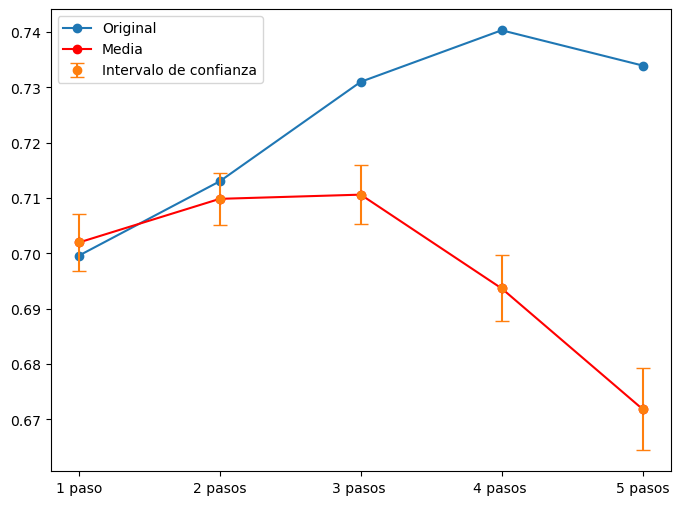

In [55]:
plt.plot(datay, 'o-', label='Original') # 'o-' means plot the points as circles and connect them with a line
plt.errorbar(range(5), means, yerr=t_crit*se, fmt='o', capsize=5, capthick=1, label='Intervalo de confianza')
plt.plot(range(5), means, 'ro-', label='Media')
plt.xticks(range(5), ['1 paso', '2 pasos', '3 pasos ', '4 pasos ', '5 pasos'])
plt.legend()
plt.show()

De manera similar, podemos calcular el intervalo de confianza con más conjuntos de datos.